# Capstone Study

In [30]:
import utils
import plots
import classifiers as clfs

%matplotlib inline

In [31]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score

import numpy as np

def test_multiple_cv(classifiers, k, x, y, metric='roc_auc'):
    print('%s-fold cross validation:\n' % k)

    for clf in classifiers:
        scores = model_selection.cross_val_score(clf, x, y, 
                                                cv=k, scoring=metric)
        print("%s: %0.2f (+/- %0.2f) [%s]" 
            % (metric.upper(), scores.mean(), scores.std(), clf.__class__.__name__))

def test_multiple(classifiers, x, y, test_x, test_y, metric=roc_auc_score):
    for clf in classifiers:
        clf.fit(x, y)
        target = clf.predict(test_x)
        score = metric(target, test_y)
        print("%s: %0.2f - [%s]" % (metric.__name__.upper(), score, clf.__class__.__name__))
        
def build_submission_skl(classifier):
    testing = utils.load_test_set()
    
    testing = testing.replace([np.inf, -np.inf], np.nan)
    testing = testing.fillna(0)
    
    x = testing.drop(['SeriousDlqin2yrs', 'Id'], axis=1).as_matrix()
    x = preprocessing.scale(x)
    
    y_predicts = classifier.predict(x)
    y_probs = classifier.predict_proba(x)
    
    testing.SeriousDlqin2yrs = y_predicts
    testing['Probability'] = y_probs[:,:1]
    
    return testing

## Unormalized Data

We'll test the same classifiers on the raw data.

In [3]:
training_set = utils.load_training_set()

In [4]:
utils.percentage_missin(training_set)

,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,age,NumberOfTime6089DaysPastDueNotWorse,DebtRatio,NumberOfDependents,MonthlyIncome,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime3059DaysPastDueNotWorse,NumberOfTimes90DaysLate
% of missing,0,0,0,0,0,2,19,0,0,0,0


In [5]:
# There are a percentage of missing values we'll fill with 0's
training_set = training_set.fillna(0)
training_set.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
utils.percentage_missin(training_set)

,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,age,NumberOfTime6089DaysPastDueNotWorse,DebtRatio,NumberOfDependents,MonthlyIncome,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime3059DaysPastDueNotWorse,NumberOfTimes90DaysLate
% of missing,0,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn import preprocessing

y = training_set['SeriousDlqin2yrs'].as_matrix()
x = training_set.drop(['SeriousDlqin2yrs'], axis=1).as_matrix()
# Basic scaling
x = preprocessing.scale(x)

In [8]:
x_train, x_test, y_train, y_test = utils.split_dataset(x, y)

Dataset splitted from: 
	x=(150000, 10), y=(150000,)
To: 
Train Set
	x=(100500, 10), y=(100500,)
Test Set
	x=(49500, 10), y=(49500,)


## Algorithm Selection and Validation Selection

According to the Survey on the Competition Forum the Algorithms used were:

* [XGBooost](https://www.kaggle.com/c/GiveMeSomeCredit/discussion/31514)
* [AdaBoost, GradBoost, KNN, Logistic, and RandomForest](https://www.kaggle.com/c/GiveMeSomeCredit/discussion/23179)

The validation would be a simple Strat-K-FoldCV, and then use them on the test set, about 10% of the training set.

My selection of classifiers goes according to my Survey on the Forums, and my Proposal initial ideas.

> I've ordered them on this list according to the Proposal, with simpler models first, and other ideas.

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                              GradientBoostingClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
# Credits to: https://www.kaggle.com/c/GiveMeSomeCredit/discussion/31514
best_xgb = XGBClassifier(
    **{'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 5,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'gamma': 0.65,
    'n_estimators' : 391
    }
)
ann = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

classifiers = [GaussianNB(), 
               DecisionTreeClassifier(),
               LogisticRegression(),
               ann,
               # Ensembles
               AdaBoostClassifier(), 
               RandomForestClassifier(), 
               GradientBoostingClassifier(),
               BaggingClassifier(),
               best_xgb]

In [10]:
test_multiple_cv(classifiers, 10, x_train, y_train)

10-fold cross validation:

ROC_AUC: 0.71 (+/- 0.01) [GaussianNB]
ROC_AUC: 0.61 (+/- 0.01) [DecisionTreeClassifier]
ROC_AUC: 0.70 (+/- 0.01) [LogisticRegression]
ROC_AUC: 0.83 (+/- 0.01) [MLPClassifier]
ROC_AUC: 0.86 (+/- 0.01) [AdaBoostClassifier]
ROC_AUC: 0.78 (+/- 0.01) [RandomForestClassifier]
ROC_AUC: 0.86 (+/- 0.01) [GradientBoostingClassifier]
ROC_AUC: 0.78 (+/- 0.01) [BaggingClassifier]
ROC_AUC: 0.86 (+/- 0.01) [XGBClassifier]


In [11]:
test_multiple_cv(classifiers, 10, x_train, y_train, metric='accuracy')

10-fold cross validation:

ACCURACY: 0.93 (+/- 0.00) [GaussianNB]
ACCURACY: 0.90 (+/- 0.00) [DecisionTreeClassifier]
ACCURACY: 0.93 (+/- 0.00) [LogisticRegression]
ACCURACY: 0.93 (+/- 0.00) [MLPClassifier]
ACCURACY: 0.94 (+/- 0.00) [AdaBoostClassifier]
ACCURACY: 0.93 (+/- 0.00) [RandomForestClassifier]
ACCURACY: 0.94 (+/- 0.00) [GradientBoostingClassifier]
ACCURACY: 0.93 (+/- 0.00) [BaggingClassifier]
ACCURACY: 0.94 (+/- 0.00) [XGBClassifier]


**The accuracy is quite useless for this case/dataset**, even lower AUC [GaussianNB] get a good Accuracy.

We should test them in the test set to be sure.

In [12]:
test_multiple(classifiers, x_train, y_train, x_test, y_test)

ROC_AUC_SCORE: 0.67 - [GaussianNB]
ROC_AUC_SCORE: 0.60 - [DecisionTreeClassifier]
ROC_AUC_SCORE: 0.74 - [LogisticRegression]
ROC_AUC_SCORE: 0.74 - [MLPClassifier]
ROC_AUC_SCORE: 0.75 - [AdaBoostClassifier]
ROC_AUC_SCORE: 0.72 - [RandomForestClassifier]
ROC_AUC_SCORE: 0.77 - [GradientBoostingClassifier]
ROC_AUC_SCORE: 0.71 - [BaggingClassifier]
ROC_AUC_SCORE: 0.76 - [XGBClassifier]


In [32]:
# We'll select the GBC with 0.77 to submit in this feature set
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf.fit(x_train, y_train)
submission_set = build_submission_skl(clf)

submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'first_submission_gb.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

> We have very bad values compared to the AUCs from the Competition on this simple test.

![](images/first_submission.png)

We'll need to find better feature sets before messing with the classifiers

## Features

These features are based on the [Winners Features](https://www.kaggle.com/c/GiveMeSomeCredit/discussion/1166#7269).

There are results around .8 > with these set of features, it's a good start.

Compared to the dataset feature set (10 features), there are 80 features, a lot more to work on.

In [10]:
features_set = utils.load_features_set()
features_set.head()

,SeriousDlqin2yrs,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,LogDebt,...,LogDebtPer90DaysLate,LogUnknownIncomeDebtRatio,LogUnknownIncomeDebtRatioPerPerson,LogUnknownIncomeDebtRatioPerLine,LogUnknownIncomeDebtRatioPerRealEstateLine,LogUnknownIncomeDebtRatioPerDelinquency,LogUnknownIncomeDebtRatioPer90DaysLate,LogNumberRealEstateLoansOrLines,LowAge,Logage
0,1,0,0,0,0,0,0,0.0,0,8.898802,...,8.898802,0.0,-1.098612,-2.639057,-1.945910,-1.098612,0.000000,1.791759,0,3.332205
1,0,0,0,0,0,0,0,0.0,0,5.758517,...,5.758517,0.0,-0.693147,-1.609438,0.000000,0.000000,0.000000,0.000000,0,3.135494
2,0,0,0,1,0,0,0,0.0,0,5.556499,...,4.863352,0.0,0.000000,-1.098612,0.000000,-1.098612,-0.693147,0.000000,0,3.044522
3,0,0,0,1,0,0,0,0.0,0,4.778821,...,4.778821,0.0,0.000000,-1.791759,0.000000,0.000000,0.000000,0.000000,0,2.564949
4,0,0,0,1,0,0,0,0.0,0,7.368324,...,7.368324,0.0,0.000000,-2.079442,-0.693147,-0.693147,0.000000,0.000000,0,3.465736


In [11]:
y = features_set['SeriousDlqin2yrs'].as_matrix()
x = features_set.drop(['SeriousDlqin2yrs'], axis=1).as_matrix()

In [12]:
x_train_f, x_test_f, y_train_f, y_test_f = utils.split_dataset(x, y)

Dataset splitted from: 
	x=(150000, 80), y=(150000,)
To: 
Train Set
	x=(100500, 80), y=(100500,)
Test Set
	x=(49500, 80), y=(49500,)


In [16]:
test_multiple_cv(classifiers, 10, x_train_f, y_train_f)

10-fold cross validation:

ROC_AUC: 0.83 (+/- 0.01) [GaussianNB]
ROC_AUC: 0.61 (+/- 0.00) [DecisionTreeClassifier]
ROC_AUC: 0.86 (+/- 0.01) [LogisticRegression]
ROC_AUC: 0.58 (+/- 0.02) [MLPClassifier]
ROC_AUC: 0.86 (+/- 0.01) [AdaBoostClassifier]
ROC_AUC: 0.78 (+/- 0.01) [RandomForestClassifier]
ROC_AUC: 0.86 (+/- 0.01) [GradientBoostingClassifier]
ROC_AUC: 0.78 (+/- 0.01) [BaggingClassifier]
ROC_AUC: 0.86 (+/- 0.01) [XGBClassifier]


In [17]:
test_multiple(classifiers, x_train_f, y_train_f, x_test_f, y_test_f)

ROC_AUC_SCORE: 0.67 - [GaussianNB]
ROC_AUC_SCORE: 0.60 - [DecisionTreeClassifier]
ROC_AUC_SCORE: 0.77 - [LogisticRegression]
ROC_AUC_SCORE: 0.47 - [MLPClassifier]
ROC_AUC_SCORE: 0.75 - [AdaBoostClassifier]
ROC_AUC_SCORE: 0.72 - [RandomForestClassifier]
ROC_AUC_SCORE: 0.77 - [GradientBoostingClassifier]
ROC_AUC_SCORE: 0.71 - [BaggingClassifier]
ROC_AUC_SCORE: 0.76 - [XGBClassifier]


> Seems like a good start, yet there were results with .8 AUC in the Test Set on the Competition.

** The MLP is too simple for this Feature set of 80 features**, it should be bigger

In [19]:
# It will take a long time to train
ann = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(40, 6), random_state=1)

test_multiple([ann], x_train_f, y_train_f, x_test_f, y_test_f)

ROC_AUC_SCORE: 0.50 - [MLPClassifier]


A simple MLP might not be that good, let's build a bigger one with Keras.

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score
from keras_tqdm import TQDMCallback
from keras.callbacks import EarlyStopping

batch_size = 4096
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
progress = TQDMCallback(leave_outer=False)

model = Sequential()
model.add(Dense(160, activation='tanh', input_shape=(80,)))
model.add(Dense(80, activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train_f, y_train_f,
          batch_size=batch_size,
          epochs=10, verbose=0,
          validation_data=(x_test_f, y_test_f),
          callbacks = [early, progress])

model.save('credit_scoring.h5')

y_pred = model.predict_classes(x_test_f)

print("%s: %0.2f - [%s]" % (roc_auc_score.__name__.upper(), roc_auc_score(y_pred, y_test_f), 'Keras MLP'))

Epoch: 0 - loss: 0.087, acc: 0.886:  86%|████████▌ | 86016/100500 [00:01<00:00, 27421.79it/s]
Epoch: 0 - loss: 0.084, acc: 0.892, val_loss: 0.065, val_acc: 0.931: 100%|██████████| 100500/100500 [00:01<00:00, 33953.05it/s]
Epoch: 1 - loss: 0.064, acc: 0.932:  94%|█████████▎| 94208/100500 [00:00<00:00, 219086.14it/s]
Epoch: 1 - loss: 0.064, acc: 0.931, val_loss: 0.062, val_acc: 0.933: 100%|██████████| 100500/100500 [00:00<00:00, 78759.26it/s]
Epoch: 2 - loss: 0.064, acc: 0.931:  94%|█████████▎| 94208/100500 [00:00<00:00, 175086.72it/s]
Epoch: 2 - loss: 0.064, acc: 0.931, val_loss: 0.070, val_acc: 0.916: 100%|██████████| 100500/100500 [00:00<00:00, 95347.80it/s]
Epoch: 3 - loss: 0.063, acc: 0.931:  82%|████████▏ | 81920/100500 [00:00<00:00, 176195.97it/s]
Epoch: 3 - loss: 0.063, acc: 0.931, val_loss: 0.064, val_acc: 0.930: 100%|██████████| 100500/100500 [00:00<00:00, 159572.28it/s]
Epoch: 4 - loss: 0.063, acc: 0.931:  82%|████████▏ | 81920/100500 [00:00<00:00, 249823.11it/s]
Epoch: 4 - lo

ROC_AUC_SCORE: 0.79 - [Keras MLP]


**Tahn in the middle layers, and sigmoid in the last layers shows us a good result.**

> ROC_AUC_SCORE: 0.79 - [Keras MLP] VS ROC_AUC_SCORE: 0.77 - [GradientBoostingClassifier] in our Test Set

With random Initializations I've managed between a 0.78 - 0.90 ROC_AUC_SCORE, so a NNET will be optimized with about 3 to 4 tanh hidden layers, and a sigmoid input/output layer.

Lets check the submission with this network model.

In [3]:
submission_set = utils.load_test_set()
submission_set.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [4]:
submission_feature_set = utils.load_test_feature_set()
submission_feature_set = submission_feature_set.drop(['SeriousDlqin2yrs'], axis=1)
submission_feature_set.head()

,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,LogDebt,RevolvingLines,...,LogDebtPer90DaysLate,LogUnknownIncomeDebtRatio,LogUnknownIncomeDebtRatioPerPerson,LogUnknownIncomeDebtRatioPerLine,LogUnknownIncomeDebtRatioPerRealEstateLine,LogUnknownIncomeDebtRatioPerDelinquency,LogUnknownIncomeDebtRatioPer90DaysLate,LogNumberRealEstateLoansOrLines,LowAge,Logage
0,0,0,1,0,0,0,0.0,0,6.919508,4,...,6.919508,0.0,0.000000,-1.609438,0.000000,0.000000,0.0,0.000000,0,3.258097
1,0,0,0,0,0,0,0.0,0,8.480420,11,...,8.480420,0.0,-1.098612,-2.772589,-1.609438,0.000000,0.0,1.386294,0,3.688879
2,0,0,0,0,0,0,0.0,0,8.159178,11,...,8.159178,0.0,-1.098612,-2.564949,-0.693147,0.000000,0.0,0.000000,0,3.737670
3,0,0,1,0,0,0,0.0,0,7.993983,5,...,7.993983,0.0,0.000000,-2.079442,-1.098612,-0.693147,0.0,0.693147,0,3.044522
4,0,0,0,0,0,0,0.0,0,4.343547,4,...,4.343547,0.0,-0.693147,-1.609438,0.000000,0.000000,0.0,0.000000,0,2.302585


In [9]:
from keras.models import load_model
# load the keras model
model = load_model('credit_scoring.h5')

x = submission_feature_set.as_matrix()

y_predicts = model.predict_classes(x)
y_probs = model.predict(x)

submission_set.SeriousDlqin2yrs = y_predicts
submission_set['Probability'] = y_probs

submission_set.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Probability
0,1,0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,0.078274
1,2,0,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,0.121120
2,3,0,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,0.048864
3,4,0,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,0.105179
4,5,0,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,0.126238


In [14]:
submission_set.count()
# We expect the solution file to have 101503 prediction rows.

Id                                      101503
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines    101503
age                                     101503
NumberOfTime30-59DaysPastDueNotWorse    101503
DebtRatio                               101503
MonthlyIncome                            81400
NumberOfOpenCreditLinesAndLoans         101503
NumberOfTimes90DaysLate                 101503
NumberRealEstateLoansOrLines            101503
NumberOfTime60-89DaysPastDueNotWorse    101503
NumberOfDependents                       98877
Probability                             101503
dtype: int64

** Lets count the predictions of each class, check if it's ok (not just full one class or anything) **

In [10]:
submission_set.query('SeriousDlqin2yrs == 0').count()

Id                                      101467
SeriousDlqin2yrs                        101467
RevolvingUtilizationOfUnsecuredLines    101467
age                                     101467
NumberOfTime30-59DaysPastDueNotWorse    101467
DebtRatio                               101467
MonthlyIncome                            81369
NumberOfOpenCreditLinesAndLoans         101467
NumberOfTimes90DaysLate                 101467
NumberRealEstateLoansOrLines            101467
NumberOfTime60-89DaysPastDueNotWorse    101467
NumberOfDependents                       98841
Probability                             101467
dtype: int64

In [11]:
submission_set.query('SeriousDlqin2yrs == 1').count()

Id                                      36
SeriousDlqin2yrs                        36
RevolvingUtilizationOfUnsecuredLines    36
age                                     36
NumberOfTime30-59DaysPastDueNotWorse    36
DebtRatio                               36
MonthlyIncome                           31
NumberOfOpenCreditLinesAndLoans         36
NumberOfTimes90DaysLate                 36
NumberRealEstateLoansOrLines            36
NumberOfTime60-89DaysPastDueNotWorse    36
NumberOfDependents                      36
Probability                             36
dtype: int64

In [15]:
# Submission must be prob and id:
import pandas as pd
submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'submission.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

** First submission was bad **:
![](images/first_submission.png)

Training the classifier with this set of data might not be ok, we need to split it better.
And we also need to compute the ROC_AUC_SCORE at the end of each epoch on the validation set.
We might do that using a Callback function.

## Checkpoint

Second try, using a smaller dataset split only

In [1]:
def build_submission_keras(model):
    submission_feature_set = utils.load_test_feature_set()
    submission_feature_set = submission_feature_set.drop(['SeriousDlqin2yrs'], axis=1)
    x = submission_feature_set.as_matrix()

    y_predicts = model.predict_classes(x)
    y_probs = model.predict(x)
    
    submission_set = utils.load_test_set()
    submission_set .SeriousDlqin2yrs = y_predicts
    submission_set ['Probability'] = y_probs
    
    return submission_set

In [2]:
import utils
features_set = utils.load_features_set()
y = features_set['SeriousDlqin2yrs'].as_matrix()
x = features_set.drop(['SeriousDlqin2yrs'], axis=1).as_matrix()
x_train_f, x_test_f, y_train_f, y_test_f = utils.split_dataset(x, y, portion=0.10)

/media/rodsnjr/Files/miniconda3/envs/udacity-ml/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Dataset splitted from: 
	x=(150000, 80), y=(150000,)
To: 
Train Set
	x=(135000, 80), y=(135000,)
Test Set
	x=(15000, 80), y=(15000,)


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score
from keras_tqdm import TQDMCallback
from keras.callbacks import EarlyStopping, LambdaCallback

def roc_callback(epochs, logs):
    try:
        print 'EPOCH %s ROC_AUC_SCORE %s' % (epochs, roc_auc_score(model.predict_classes(x_test_f), y_test_f))
    except ValueError:
        print 'ROC_AUC_SCORE is 0, only one class present in the predictions'

batch_size = 4096
early = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')
roc_scoring = LambdaCallback(on_epoch_end=lambda epochs, logs: roc_callback(epochs, logs))
progress = TQDMCallback(leave_outer=False)

model = Sequential()
model.add(Dense(80, activation='sigmoid', input_shape=(80,)))
model.add(Dense(40, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
_________________________________________________________________


In [4]:
# try using different optimizers and different optimizer configs
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train_f, y_train_f,
          batch_size=batch_size,
          epochs=30, verbose=0,
          validation_data=(x_test_f, y_test_f),
          callbacks = [early, progress, roc_scoring])

model.save('credit_scoring.h5')

y_pred = model.predict_classes(x_test_f)

print("%s: %0.2f - [%s]" % (roc_auc_score.__name__.upper(), roc_auc_score(y_pred, y_test_f), 'Keras MLP'))

Epoch: 0 - loss: 0.073, acc: 0.932:  82%|████████▏ | 110592/135000 [00:05<00:10, 2249.39it/s]
Epoch: 0 - loss: 0.070, acc: 0.933, val_loss: 0.060, val_acc: 0.936: 100%|██████████| 135000/135000 [00:05<00:00, 3201.86it/s]
Epoch: 1 - loss: 0.063, acc: 0.933:  21%|██        | 28672/135000 [00:00<00:00, 279917.71it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 1 - loss: 0.063, acc: 0.933:  94%|█████████▍| 126976/135000 [00:00<00:00, 296236.62it/s]
Epoch: 1 - loss: 0.063, acc: 0.933, val_loss: 0.060, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 223237.16it/s]
Epoch: 2 - loss: 0.062, acc: 0.933:  30%|███       | 40960/135000 [00:00<00:00, 378705.67it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 2 - loss: 0.063, acc: 0.932:  73%|███████▎  | 98304/135000 [00:00<00:00, 316446.20it/s]
Epoch: 2 - loss: 0.063, acc: 0.933, val_loss: 0.060, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 317288.98it/s]
Epoch: 3 - loss: 0.063, acc: 0.932:  24%|██▍       | 32768/135000 [00:00<00:00, 305051.80it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 3 - loss: 0.063, acc: 0.933:  97%|█████████▋| 131072/135000 [00:00<00:00, 316725.10it/s]
Epoch: 3 - loss: 0.063, acc: 0.933, val_loss: 0.060, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 200097.72it/s]
Epoch: 4 - loss: 0.063, acc: 0.932:  21%|██        | 28672/135000 [00:00<00:00, 256272.25it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 4 - loss: 0.062, acc: 0.933:  91%|█████████ | 122880/135000 [00:00<00:00, 223130.78it/s]
Epoch: 4 - loss: 0.063, acc: 0.933, val_loss: 0.060, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 226522.22it/s]
Epoch: 5 - loss: 0.060, acc: 0.936:  12%|█▏        | 16384/135000 [00:00<00:00, 151304.50it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 5 - loss: 0.062, acc: 0.933:  82%|████████▏ | 110592/135000 [00:00<00:00, 191104.59it/s]
Epoch: 5 - loss: 0.062, acc: 0.933, val_loss: 0.060, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 177598.97it/s]
Epoch: 6 - loss: 0.062, acc: 0.933:  21%|██        | 28672/135000 [00:00<00:00, 271368.42it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 6 - loss: 0.062, acc: 0.933:  94%|█████████▍| 126976/135000 [00:00<00:00, 177770.47it/s]
Epoch: 6 - loss: 0.062, acc: 0.933, val_loss: 0.059, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 131960.85it/s]
Epoch: 7 - loss: 0.060, acc: 0.934:  36%|███▋      | 49152/135000 [00:00<00:00, 472910.94it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 7 - loss: 0.061, acc: 0.933:  73%|███████▎  | 98304/135000 [00:00<00:00, 468207.97it/s]
Epoch: 7 - loss: 0.061, acc: 0.933, val_loss: 0.058, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 441759.05it/s]
Epoch: 8 - loss: 0.059, acc: 0.934:  36%|███▋      | 49152/135000 [00:00<00:00, 471500.55it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 8 - loss: 0.060, acc: 0.933:  70%|██████▉   | 94208/135000 [00:00<00:00, 464266.39it/s]
Epoch: 8 - loss: 0.059, acc: 0.933, val_loss: 0.056, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 448445.31it/s]
Epoch: 9 - loss: 0.058, acc: 0.933:  15%|█▌        | 20480/135000 [00:00<00:00, 191618.57it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 9 - loss: 0.057, acc: 0.933:  88%|████████▊ | 118784/135000 [00:00<00:00, 179468.26it/s]
Epoch: 9 - loss: 0.057, acc: 0.933, val_loss: 0.053, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 168067.83it/s]
Epoch: 10 - loss: 0.056, acc: 0.931:  30%|███       | 40960/135000 [00:00<00:00, 404959.24it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 10 - loss: 0.055, acc: 0.933:  88%|████████▊ | 118784/135000 [00:00<00:00, 346190.99it/s]
Epoch: 10 - loss: 0.055, acc: 0.933, val_loss: 0.051, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 343127.57it/s]
Epoch: 11 - loss: 0.053, acc: 0.933:  36%|███▋      | 49152/135000 [00:00<00:00, 479059.42it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 11 - loss: 0.053, acc: 0.933:  73%|███████▎  | 98304/135000 [00:00<00:00, 477242.56it/s]
Epoch: 11 - loss: 0.053, acc: 0.933, val_loss: 0.051, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 435983.71it/s]
Epoch: 12 - loss: 0.053, acc: 0.931:  15%|█▌        | 20480/135000 [00:00<00:00, 200979.27it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 12 - loss: 0.052, acc: 0.934:  82%|████████▏ | 110592/135000 [00:00<00:00, 244574.35it/s]
Epoch: 12 - loss: 0.052, acc: 0.933, val_loss: 0.051, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 272722.04it/s]
Epoch: 13 - loss: 0.054, acc: 0.932:  36%|███▋      | 49152/135000 [00:00<00:00, 450881.67it/s]

EPOCH 12 ROC_AUC_SCORE 0.84305814884



Epoch: 13 - loss: 0.052, acc: 0.933:  82%|████████▏ | 110592/135000 [00:00<00:00, 222997.39it/s]
Epoch: 13 - loss: 0.052, acc: 0.933, val_loss: 0.050, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 251456.41it/s]
Epoch: 14 - loss: 0.052, acc: 0.934:  30%|███       | 40960/135000 [00:00<00:00, 373992.50it/s]

EPOCH 13 ROC_AUC_SCORE 0.682678631092



Epoch: 14 - loss: 0.052, acc: 0.933:  97%|█████████▋| 131072/135000 [00:00<00:00, 217263.94it/s]
Epoch: 14 - loss: 0.051, acc: 0.933, val_loss: 0.050, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 138985.79it/s]
Epoch: 15 - loss: 0.050, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 204091.72it/s]

EPOCH 14 ROC_AUC_SCORE 0.672789501897



Epoch: 15 - loss: 0.052, acc: 0.933:  88%|████████▊ | 118784/135000 [00:00<00:00, 173027.51it/s]
Epoch: 15 - loss: 0.052, acc: 0.933, val_loss: 0.050, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 163339.60it/s]
Epoch: 16 - loss: 0.052, acc: 0.933:  15%|█▌        | 20480/135000 [00:00<00:00, 168565.27it/s]

EPOCH 15 ROC_AUC_SCORE 0.699774726011



Epoch: 16 - loss: 0.052, acc: 0.934:  91%|█████████ | 122880/135000 [00:00<00:00, 171648.58it/s]
Epoch: 16 - loss: 0.052, acc: 0.934, val_loss: 0.050, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 158275.99it/s]
Epoch: 17 - loss: 0.052, acc: 0.934:  36%|███▋      | 49152/135000 [00:00<00:00, 472874.06it/s]

EPOCH 16 ROC_AUC_SCORE 0.719140090354



Epoch: 17 - loss: 0.051, acc: 0.934:  85%|████████▍ | 114688/135000 [00:00<00:00, 335503.69it/s]
Epoch: 17 - loss: 0.051, acc: 0.935, val_loss: 0.049, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 249547.95it/s]
Epoch: 18 - loss: 0.051, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 184926.24it/s]

EPOCH 17 ROC_AUC_SCORE 0.713743739192



Epoch: 18 - loss: 0.051, acc: 0.935:  97%|█████████▋| 131072/135000 [00:00<00:00, 185726.76it/s]
Epoch: 18 - loss: 0.051, acc: 0.935, val_loss: 0.049, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 113267.64it/s]
Epoch: 19 - loss: 0.049, acc: 0.936:  18%|█▊        | 24576/135000 [00:00<00:00, 206084.65it/s]

EPOCH 18 ROC_AUC_SCORE 0.723433729151



Epoch: 19 - loss: 0.051, acc: 0.935:  73%|███████▎  | 98304/135000 [00:00<00:00, 220220.44it/s]
Epoch: 19 - loss: 0.051, acc: 0.935, val_loss: 0.049, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 252489.10it/s]
Epoch: 20 - loss: 0.051, acc: 0.933:  21%|██        | 28672/135000 [00:00<00:00, 249701.70it/s]

EPOCH 19 ROC_AUC_SCORE 0.729940841723



Epoch: 20 - loss: 0.051, acc: 0.936:  97%|█████████▋| 131072/135000 [00:00<00:00, 180574.28it/s]
Epoch: 20 - loss: 0.051, acc: 0.936, val_loss: 0.050, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 124562.48it/s]
Epoch: 21 - loss: 0.049, acc: 0.937:  18%|█▊        | 24576/135000 [00:00<00:00, 245049.21it/s]

EPOCH 20 ROC_AUC_SCORE 0.739671021407



Epoch: 21 - loss: 0.051, acc: 0.936:  76%|███████▌  | 102400/135000 [00:00<00:00, 188590.06it/s]
Epoch: 21 - loss: 0.051, acc: 0.935, val_loss: 0.049, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 203997.22it/s]
Epoch: 22 - loss: 0.052, acc: 0.934:  18%|█▊        | 24576/135000 [00:00<00:00, 214603.51it/s]

EPOCH 21 ROC_AUC_SCORE 0.720157924422



Epoch: 22 - loss: 0.051, acc: 0.936:  85%|████████▍ | 114688/135000 [00:00<00:00, 219885.26it/s]
Epoch: 22 - loss: 0.051, acc: 0.936, val_loss: 0.050, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 218801.97it/s]
Epoch: 23 - loss: 0.052, acc: 0.935:  36%|███▋      | 49152/135000 [00:00<00:00, 458751.71it/s]

EPOCH 22 ROC_AUC_SCORE 0.729410171179



Epoch: 23 - loss: 0.051, acc: 0.935:  73%|███████▎  | 98304/135000 [00:00<00:00, 463064.05it/s]
Epoch: 23 - loss: 0.051, acc: 0.936, val_loss: 0.049, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 443639.00it/s]
Epoch: 24 - loss: 0.050, acc: 0.936:  36%|███▋      | 49152/135000 [00:00<00:00, 477927.74it/s]

EPOCH 23 ROC_AUC_SCORE 0.73349047536



Epoch: 24 - loss: 0.051, acc: 0.936:  73%|███████▎  | 98304/135000 [00:00<00:00, 472730.49it/s]
Epoch: 24 - loss: 0.051, acc: 0.935, val_loss: 0.049, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 430198.94it/s]
Epoch: 25 - loss: 0.051, acc: 0.937:  36%|███▋      | 49152/135000 [00:00<00:00, 469554.63it/s]

EPOCH 24 ROC_AUC_SCORE 0.737652056999



Epoch: 25 - loss: 0.052, acc: 0.935:  73%|███████▎  | 98304/135000 [00:00<00:00, 469751.07it/s]
Epoch: 25 - loss: 0.051, acc: 0.936, val_loss: 0.049, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 425407.08it/s]
Epoch: 26 - loss: 0.050, acc: 0.937:  30%|███       | 40960/135000 [00:00<00:00, 390217.44it/s]

EPOCH 25 ROC_AUC_SCORE 0.730792741975



Epoch: 26 - loss: 0.050, acc: 0.936:  94%|█████████▍| 126976/135000 [00:00<00:00, 399243.63it/s]
Epoch: 26 - loss: 0.050, acc: 0.936, val_loss: 0.049, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 338722.51it/s]
Epoch: 27 - loss: 0.049, acc: 0.937:  36%|███▋      | 49152/135000 [00:00<00:00, 463698.35it/s]

EPOCH 26 ROC_AUC_SCORE 0.735631548465



Epoch: 27 - loss: 0.050, acc: 0.936:  73%|███████▎  | 98304/135000 [00:00<00:00, 465409.26it/s]
Epoch: 27 - loss: 0.050, acc: 0.936, val_loss: 0.049, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 441360.95it/s]
Epoch: 28 - loss: 0.050, acc: 0.936:  36%|███▋      | 49152/135000 [00:00<00:00, 465357.36it/s]

EPOCH 27 ROC_AUC_SCORE 0.732480526552



Epoch: 28 - loss: 0.050, acc: 0.936:  73%|███████▎  | 98304/135000 [00:00<00:00, 466204.72it/s]
Epoch: 28 - loss: 0.050, acc: 0.936, val_loss: 0.049, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 424691.67it/s]
Epoch: 29 - loss: 0.050, acc: 0.936:  36%|███▋      | 49152/135000 [00:00<00:00, 470822.16it/s]

EPOCH 28 ROC_AUC_SCORE 0.735803323042



Epoch: 29 - loss: 0.050, acc: 0.937:  73%|███████▎  | 98304/135000 [00:00<00:00, 471434.57it/s]
Epoch: 29 - loss: 0.050, acc: 0.936, val_loss: 0.050, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 426625.43it/s]
                                                         

EPOCH 29 ROC_AUC_SCORE 0.729985930227


ROC_AUC_SCORE: 0.73 - [Keras MLP]


In [7]:
import pandas as pd

submission_set = build_submission_keras(model)

submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'submission.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

** Second submission was ok **:

![](images/first_submission.png)

Remember, the competition avg scores from the top 350 +- was around 0.86, so we can still improve our model.

The number of the hidden layers is good, and the number of hidden units is also good.
The improvements made were on the number of training epochs, and the optimizer to adam.

We also had epochs were the ROC_AUC was bigger than 0.80, so we'll checkpoint those.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score
from keras_tqdm import TQDMCallback
from keras.callbacks import EarlyStopping, LambdaCallback

def roc_callback(epochs, logs):
    try:
        score = roc_auc_score(model.predict_classes(x_test_f), y_test_f)
        
        if score > 0.80:
            model.save('credit_scoring_3_spc.h5')
        
        print 'EPOCH %s ROC_AUC_SCORE %s' % (epochs, score)
    except ValueError:
        print 'ROC_AUC_SCORE is 0, only one class present in the predictions'

batch_size = 4096
early = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')
roc_scoring = LambdaCallback(on_epoch_end=lambda epochs, logs: roc_callback(epochs, logs))
progress = TQDMCallback(leave_outer=False)

model = Sequential()
model.add(Dense(80, activation='tanh', input_shape=(80,)))
model.add(Dense(70, activation='tanh'))
model.add(Dense(60, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train_f, y_train_f,
          batch_size=batch_size,
          epochs=50, verbose=0,
          validation_data=(x_test_f, y_test_f),
          callbacks = [early, progress, roc_scoring])

model.save('credit_scoring_3.h5')

y_pred = model.predict_classes(x_test_f)

print("%s: %0.2f - [%s]" % (roc_auc_score.__name__.upper(), roc_auc_score(y_pred, y_test_f), 'Keras MLP'))

Epoch: 0 - loss: 0.366, acc: 0.872:  91%|█████████ | 122880/135000 [00:01<00:00, 81136.04it/s]
Epoch: 0 - loss: 0.360, acc: 0.875, val_loss: 0.277, val_acc: 0.913: 100%|██████████| 135000/135000 [00:01<00:00, 79844.32it/s]
Epoch: 1 - loss: 0.281, acc: 0.909:  18%|█▊        | 24576/135000 [00:00<00:00, 224489.82it/s]

EPOCH 0 ROC_AUC_SCORE 0.535307579383



Epoch: 1 - loss: 0.257, acc: 0.926:  91%|█████████ | 122880/135000 [00:00<00:00, 182205.62it/s]
Epoch: 1 - loss: 0.256, acc: 0.927, val_loss: 0.238, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 176682.22it/s]
Epoch: 2 - loss: 0.243, acc: 0.934:  18%|█▊        | 24576/135000 [00:00<00:00, 220600.72it/s]

EPOCH 1 ROC_AUC_SCORE 0.593016275347



Epoch: 2 - loss: 0.246, acc: 0.933:  91%|█████████ | 122880/135000 [00:00<00:00, 173521.97it/s]
Epoch: 2 - loss: 0.247, acc: 0.932, val_loss: 0.238, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 148404.76it/s]
Epoch: 3 - loss: 0.247, acc: 0.932:  15%|█▌        | 20480/135000 [00:00<00:00, 182149.52it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 3 - loss: 0.246, acc: 0.933:  94%|█████████▍| 126976/135000 [00:00<00:00, 150041.23it/s]
Epoch: 3 - loss: 0.246, acc: 0.933, val_loss: 0.237, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 131485.94it/s]
Epoch: 4 - loss: 0.250, acc: 0.931:  15%|█▌        | 20480/135000 [00:00<00:00, 191271.68it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 4 - loss: 0.246, acc: 0.932:  91%|█████████ | 122880/135000 [00:00<00:00, 182407.01it/s]
Epoch: 4 - loss: 0.245, acc: 0.933, val_loss: 0.236, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 158884.52it/s]
Epoch: 5 - loss: 0.242, acc: 0.934:  15%|█▌        | 20480/135000 [00:00<00:00, 179293.89it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 5 - loss: 0.246, acc: 0.932:  94%|█████████▍| 126976/135000 [00:00<00:00, 187732.96it/s]
Epoch: 5 - loss: 0.245, acc: 0.933, val_loss: 0.238, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 159317.10it/s]
Epoch: 6 - loss: 0.244, acc: 0.933:  18%|█▊        | 24576/135000 [00:00<00:00, 209782.21it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 6 - loss: 0.246, acc: 0.933:  88%|████████▊ | 118784/135000 [00:00<00:00, 212086.51it/s]
Epoch: 6 - loss: 0.246, acc: 0.933, val_loss: 0.237, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 194694.74it/s]
Epoch: 7 - loss: 0.249, acc: 0.931:  18%|█▊        | 24576/135000 [00:00<00:00, 227979.74it/s]

ROC_AUC_SCORE is 0, only one class present in the predictions



Epoch: 7 - loss: 0.245, acc: 0.933:  94%|█████████▍| 126976/135000 [00:00<00:00, 197710.82it/s]
Epoch: 7 - loss: 0.245, acc: 0.933, val_loss: 0.236, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 166426.81it/s]
Epoch: 8 - loss: 0.238, acc: 0.935:  18%|█▊        | 24576/135000 [00:00<00:00, 224785.02it/s]

EPOCH 7 ROC_AUC_SCORE 0.967997866524



Epoch: 8 - loss: 0.242, acc: 0.933:  91%|█████████ | 122880/135000 [00:00<00:00, 230278.31it/s]
Epoch: 8 - loss: 0.242, acc: 0.933, val_loss: 0.225, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 176246.89it/s]
Epoch: 9 - loss: 0.237, acc: 0.928:  12%|█▏        | 16384/135000 [00:00<00:00, 145365.44it/s]

EPOCH 8 ROC_AUC_SCORE 0.663525119708



Epoch: 9 - loss: 0.240, acc: 0.932:  88%|████████▊ | 118784/135000 [00:00<00:00, 150343.81it/s]
Epoch: 9 - loss: 0.242, acc: 0.931, val_loss: 0.239, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 144467.73it/s]
Epoch: 10 - loss: 0.246, acc: 0.932:  15%|█▌        | 20480/135000 [00:00<00:00, 198540.05it/s]

EPOCH 9 ROC_AUC_SCORE 0.60659854779



Epoch: 10 - loss: 0.242, acc: 0.933:  91%|█████████ | 122880/135000 [00:00<00:00, 224004.21it/s]
Epoch: 10 - loss: 0.242, acc: 0.933, val_loss: 0.230, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 193915.87it/s]
Epoch: 11 - loss: 0.226, acc: 0.937:  15%|█▌        | 20480/135000 [00:00<00:00, 191675.86it/s]

EPOCH 10 ROC_AUC_SCORE 0.968029070543



Epoch: 11 - loss: 0.232, acc: 0.933:  88%|████████▊ | 118784/135000 [00:00<00:00, 222533.14it/s]
Epoch: 11 - loss: 0.232, acc: 0.933, val_loss: 0.229, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 201018.52it/s]
Epoch: 12 - loss: 0.232, acc: 0.934:  18%|█▊        | 24576/135000 [00:00<00:00, 217490.56it/s]

EPOCH 11 ROC_AUC_SCORE 0.646674991897



Epoch: 12 - loss: 0.235, acc: 0.932:  91%|█████████ | 122880/135000 [00:00<00:00, 232767.76it/s]
Epoch: 12 - loss: 0.235, acc: 0.933, val_loss: 0.233, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 210370.05it/s]
Epoch: 13 - loss: 0.239, acc: 0.932:  15%|█▌        | 20480/135000 [00:00<00:00, 190022.20it/s]

EPOCH 12 ROC_AUC_SCORE 0.616324198372



Epoch: 13 - loss: 0.235, acc: 0.933:  85%|████████▍ | 114688/135000 [00:00<00:00, 168329.53it/s]
Epoch: 13 - loss: 0.234, acc: 0.933, val_loss: 0.225, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 155352.21it/s]
Epoch: 14 - loss: 0.229, acc: 0.932:  15%|█▌        | 20480/135000 [00:00<00:00, 179578.39it/s]

EPOCH 13 ROC_AUC_SCORE 0.745891979632



Epoch: 14 - loss: 0.230, acc: 0.933:  79%|███████▉  | 106496/135000 [00:00<00:00, 193822.03it/s]
Epoch: 14 - loss: 0.230, acc: 0.933, val_loss: 0.224, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 202772.84it/s]
Epoch: 15 - loss: 0.232, acc: 0.931:  12%|█▏        | 16384/135000 [00:00<00:00, 156123.15it/s]

EPOCH 14 ROC_AUC_SCORE 0.665755000387



Epoch: 15 - loss: 0.225, acc: 0.932:  85%|████████▍ | 114688/135000 [00:00<00:00, 171254.04it/s]
Epoch: 15 - loss: 0.224, acc: 0.932, val_loss: 0.216, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 157080.10it/s]
Epoch: 16 - loss: 0.218, acc: 0.932:  21%|██        | 28672/135000 [00:00<00:00, 252234.46it/s]

EPOCH 15 ROC_AUC_SCORE 0.72082263947



Epoch: 16 - loss: 0.210, acc: 0.933:  91%|█████████ | 122880/135000 [00:00<00:00, 166002.64it/s]
Epoch: 16 - loss: 0.210, acc: 0.933, val_loss: 0.204, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 137151.48it/s]
Epoch: 17 - loss: 0.209, acc: 0.932:  12%|█▏        | 16384/135000 [00:00<00:00, 162182.49it/s]

EPOCH 16 ROC_AUC_SCORE 0.655549626467



Epoch: 17 - loss: 0.215, acc: 0.933:  91%|█████████ | 122880/135000 [00:00<00:00, 150308.51it/s]
Epoch: 17 - loss: 0.214, acc: 0.933, val_loss: 0.197, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 144173.27it/s]
Epoch: 18 - loss: 0.195, acc: 0.936:  15%|█▌        | 20480/135000 [00:00<00:00, 179387.88it/s]

EPOCH 17 ROC_AUC_SCORE 0.671979934252



Epoch: 18 - loss: 0.198, acc: 0.933:  82%|████████▏ | 110592/135000 [00:00<00:00, 169780.72it/s]
Epoch: 18 - loss: 0.198, acc: 0.933, val_loss: 0.192, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 167121.09it/s]
Epoch: 19 - loss: 0.203, acc: 0.932:  18%|█▊        | 24576/135000 [00:00<00:00, 215681.19it/s]

EPOCH 18 ROC_AUC_SCORE 0.710854789628



Epoch: 19 - loss: 0.198, acc: 0.933:  97%|█████████▋| 131072/135000 [00:00<00:00, 168945.29it/s]
Epoch: 19 - loss: 0.199, acc: 0.933, val_loss: 0.202, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 123017.86it/s]
Epoch: 20 - loss: 0.201, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 180037.57it/s]

EPOCH 19 ROC_AUC_SCORE 0.655632674853



Epoch: 20 - loss: 0.199, acc: 0.934:  91%|█████████ | 122880/135000 [00:00<00:00, 157394.41it/s]
Epoch: 20 - loss: 0.199, acc: 0.933, val_loss: 0.197, val_acc: 0.934: 100%|██████████| 135000/135000 [00:00<00:00, 142630.16it/s]
Epoch: 21 - loss: 0.200, acc: 0.931:  15%|█▌        | 20480/135000 [00:00<00:00, 194139.49it/s]

EPOCH 20 ROC_AUC_SCORE 0.620201131845



Epoch: 21 - loss: 0.196, acc: 0.933:  97%|█████████▋| 131072/135000 [00:00<00:00, 150966.34it/s]
Epoch: 21 - loss: 0.196, acc: 0.933, val_loss: 0.190, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 97215.18it/s]
Epoch: 22 - loss: 0.202, acc: 0.930:  18%|█▊        | 24576/135000 [00:00<00:00, 212696.29it/s]

EPOCH 21 ROC_AUC_SCORE 0.655715811966



Epoch: 22 - loss: 0.194, acc: 0.934:  97%|█████████▋| 131072/135000 [00:00<00:00, 161818.68it/s]
Epoch: 22 - loss: 0.194, acc: 0.934, val_loss: 0.190, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 113906.21it/s]
Epoch: 23 - loss: 0.195, acc: 0.932:  18%|█▊        | 24576/135000 [00:00<00:00, 227810.45it/s]

EPOCH 22 ROC_AUC_SCORE 0.712449801816



Epoch: 23 - loss: 0.193, acc: 0.934:  91%|█████████ | 122880/135000 [00:00<00:00, 148853.70it/s]
Epoch: 23 - loss: 0.193, acc: 0.934, val_loss: 0.187, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 131282.95it/s]
Epoch: 24 - loss: 0.194, acc: 0.934:  15%|█▌        | 20480/135000 [00:00<00:00, 191353.49it/s]

EPOCH 23 ROC_AUC_SCORE 0.731082887701



Epoch: 24 - loss: 0.194, acc: 0.934:  97%|█████████▋| 131072/135000 [00:00<00:00, 160897.70it/s]
Epoch: 24 - loss: 0.194, acc: 0.934, val_loss: 0.200, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 101981.98it/s]
Epoch: 25 - loss: 0.204, acc: 0.930:  12%|█▏        | 16384/135000 [00:00<00:00, 135966.98it/s]

EPOCH 24 ROC_AUC_SCORE 0.703332893934



Epoch: 25 - loss: 0.195, acc: 0.933:  88%|████████▊ | 118784/135000 [00:00<00:00, 154218.20it/s]
Epoch: 25 - loss: 0.196, acc: 0.933, val_loss: 0.189, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 153302.71it/s]
Epoch: 26 - loss: 0.194, acc: 0.934:  15%|█▌        | 20480/135000 [00:00<00:00, 192909.12it/s]

EPOCH 25 ROC_AUC_SCORE 0.732940667087



Epoch: 26 - loss: 0.192, acc: 0.934:  91%|█████████ | 122880/135000 [00:00<00:00, 165577.20it/s]
Epoch: 26 - loss: 0.191, acc: 0.934, val_loss: 0.185, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 147576.36it/s]
Epoch: 27 - loss: 0.176, acc: 0.939:  15%|█▌        | 20480/135000 [00:00<00:00, 168850.23it/s]

EPOCH 26 ROC_AUC_SCORE 0.685003340013



Epoch: 27 - loss: 0.190, acc: 0.934:  88%|████████▊ | 118784/135000 [00:00<00:00, 165719.24it/s]
Epoch: 27 - loss: 0.190, acc: 0.934, val_loss: 0.184, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 151655.92it/s]
Epoch: 28 - loss: 0.193, acc: 0.933:  12%|█▏        | 16384/135000 [00:00<00:00, 161401.22it/s]

EPOCH 27 ROC_AUC_SCORE 0.704419159551



Epoch: 28 - loss: 0.188, acc: 0.935:  88%|████████▊ | 118784/135000 [00:00<00:00, 154152.64it/s]
Epoch: 28 - loss: 0.190, acc: 0.934, val_loss: 0.192, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 146009.28it/s]
Epoch: 29 - loss: 0.202, acc: 0.933:  12%|█▏        | 16384/135000 [00:00<00:00, 157261.80it/s]

EPOCH 28 ROC_AUC_SCORE 0.736908019704



Epoch: 29 - loss: 0.192, acc: 0.934:  94%|█████████▍| 126976/135000 [00:00<00:00, 166691.66it/s]
Epoch: 29 - loss: 0.192, acc: 0.934, val_loss: 0.185, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 139256.05it/s]
Epoch: 30 - loss: 0.189, acc: 0.935:  12%|█▏        | 16384/135000 [00:00<00:00, 157086.73it/s]

EPOCH 29 ROC_AUC_SCORE 0.701957685427



Epoch: 30 - loss: 0.194, acc: 0.934:  94%|█████████▍| 126976/135000 [00:00<00:00, 156094.17it/s]
Epoch: 30 - loss: 0.194, acc: 0.934, val_loss: 0.189, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 125988.95it/s]
Epoch: 31 - loss: 0.201, acc: 0.932:  18%|█▊        | 24576/135000 [00:00<00:00, 227764.14it/s]

EPOCH 30 ROC_AUC_SCORE 0.750669689912



Epoch: 31 - loss: 0.198, acc: 0.934:  97%|█████████▋| 131072/135000 [00:00<00:00, 179523.28it/s]
Epoch: 31 - loss: 0.197, acc: 0.934, val_loss: 0.187, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 117904.24it/s]
Epoch: 32 - loss: 0.188, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 164732.02it/s]

EPOCH 31 ROC_AUC_SCORE 0.685862576134



Epoch: 32 - loss: 0.190, acc: 0.934:  94%|█████████▍| 126976/135000 [00:00<00:00, 157522.08it/s]
Epoch: 32 - loss: 0.190, acc: 0.934, val_loss: 0.185, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 131151.25it/s]
Epoch: 33 - loss: 0.191, acc: 0.932:  15%|█▌        | 20480/135000 [00:00<00:00, 193649.74it/s]

EPOCH 32 ROC_AUC_SCORE 0.779803864276



Epoch: 33 - loss: 0.188, acc: 0.935:  88%|████████▊ | 118784/135000 [00:00<00:00, 171505.13it/s]
Epoch: 33 - loss: 0.188, acc: 0.935, val_loss: 0.183, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 148044.98it/s]
Epoch: 34 - loss: 0.189, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 186381.56it/s]

EPOCH 33 ROC_AUC_SCORE 0.721956834298



Epoch: 34 - loss: 0.190, acc: 0.934:  88%|████████▊ | 118784/135000 [00:00<00:00, 220618.20it/s]
Epoch: 34 - loss: 0.190, acc: 0.934, val_loss: 0.184, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 197473.96it/s]
Epoch: 35 - loss: 0.187, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 194721.28it/s]

EPOCH 34 ROC_AUC_SCORE 0.754992327655



Epoch: 35 - loss: 0.188, acc: 0.935:  97%|█████████▋| 131072/135000 [00:00<00:00, 158626.04it/s]
Epoch: 35 - loss: 0.188, acc: 0.935, val_loss: 0.185, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 115423.46it/s]
Epoch: 36 - loss: 0.189, acc: 0.932:  15%|█▌        | 20480/135000 [00:00<00:00, 185115.13it/s]

EPOCH 35 ROC_AUC_SCORE 0.709083758172



Epoch: 36 - loss: 0.186, acc: 0.934:  91%|█████████ | 122880/135000 [00:00<00:00, 147167.47it/s]
Epoch: 36 - loss: 0.187, acc: 0.934, val_loss: 0.181, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 134034.49it/s]
Epoch: 37 - loss: 0.194, acc: 0.930:  12%|█▏        | 16384/135000 [00:00<00:00, 156106.48it/s]

EPOCH 36 ROC_AUC_SCORE 0.728302220294



Epoch: 37 - loss: 0.187, acc: 0.934:  94%|█████████▍| 126976/135000 [00:00<00:00, 158561.27it/s]
Epoch: 37 - loss: 0.187, acc: 0.934, val_loss: 0.180, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 134070.87it/s]
Epoch: 38 - loss: 0.189, acc: 0.933:  15%|█▌        | 20480/135000 [00:00<00:00, 178393.91it/s]

EPOCH 37 ROC_AUC_SCORE 0.732764432004



Epoch: 38 - loss: 0.192, acc: 0.934:  85%|████████▍ | 114688/135000 [00:00<00:00, 168853.06it/s]
Epoch: 38 - loss: 0.191, acc: 0.934, val_loss: 0.182, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 154514.84it/s]
Epoch: 39 - loss: 0.182, acc: 0.937:  12%|█▏        | 16384/135000 [00:00<00:00, 140815.14it/s]

EPOCH 38 ROC_AUC_SCORE 0.736816549829



Epoch: 39 - loss: 0.189, acc: 0.933:  91%|█████████ | 122880/135000 [00:00<00:00, 183640.31it/s]
Epoch: 39 - loss: 0.188, acc: 0.934, val_loss: 0.181, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 154985.41it/s]
Epoch: 40 - loss: 0.186, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 204309.67it/s]

EPOCH 39 ROC_AUC_SCORE 0.73581239531



Epoch: 40 - loss: 0.187, acc: 0.935:  85%|████████▍ | 114688/135000 [00:00<00:00, 192435.19it/s]
Epoch: 40 - loss: 0.187, acc: 0.934, val_loss: 0.183, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 166208.41it/s]
Epoch: 41 - loss: 0.183, acc: 0.937:  18%|█▊        | 24576/135000 [00:00<00:00, 218257.31it/s]

EPOCH 40 ROC_AUC_SCORE 0.741182432432



Epoch: 41 - loss: 0.186, acc: 0.936:  88%|████████▊ | 118784/135000 [00:00<00:00, 221097.38it/s]
Epoch: 41 - loss: 0.187, acc: 0.935, val_loss: 0.184, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 172839.98it/s]
Epoch: 42 - loss: 0.195, acc: 0.931:  18%|█▊        | 24576/135000 [00:00<00:00, 216018.37it/s]

EPOCH 41 ROC_AUC_SCORE 0.741666318134



Epoch: 42 - loss: 0.188, acc: 0.935:  91%|█████████ | 122880/135000 [00:00<00:00, 175665.84it/s]
Epoch: 42 - loss: 0.188, acc: 0.934, val_loss: 0.182, val_acc: 0.938: 100%|██████████| 135000/135000 [00:00<00:00, 147835.01it/s]
Epoch: 43 - loss: 0.185, acc: 0.933:  18%|█▊        | 24576/135000 [00:00<00:00, 222745.87it/s]

EPOCH 42 ROC_AUC_SCORE 0.754939441318



Epoch: 43 - loss: 0.186, acc: 0.934:  88%|████████▊ | 118784/135000 [00:00<00:00, 173081.93it/s]
Epoch: 43 - loss: 0.186, acc: 0.934, val_loss: 0.182, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 158937.17it/s]
Epoch: 44 - loss: 0.183, acc: 0.935:  18%|█▊        | 24576/135000 [00:00<00:00, 217029.89it/s]

EPOCH 43 ROC_AUC_SCORE 0.713843457263



Epoch: 44 - loss: 0.186, acc: 0.934:  94%|█████████▍| 126976/135000 [00:00<00:00, 235788.02it/s]
Epoch: 44 - loss: 0.186, acc: 0.934, val_loss: 0.183, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 175602.69it/s]
Epoch: 45 - loss: 0.180, acc: 0.937:  18%|█▊        | 24576/135000 [00:00<00:00, 227969.15it/s]

EPOCH 44 ROC_AUC_SCORE 0.678934693794



Epoch: 45 - loss: 0.187, acc: 0.936:  97%|█████████▋| 131072/135000 [00:00<00:00, 241925.76it/s]
Epoch: 45 - loss: 0.187, acc: 0.935, val_loss: 0.181, val_acc: 0.937: 100%|██████████| 135000/135000 [00:00<00:00, 143589.68it/s]
Epoch: 46 - loss: 0.192, acc: 0.933:  15%|█▌        | 20480/135000 [00:00<00:00, 204283.44it/s]

EPOCH 45 ROC_AUC_SCORE 0.739002379255



Epoch: 46 - loss: 0.185, acc: 0.936:  94%|█████████▍| 126976/135000 [00:00<00:00, 232389.56it/s]
Epoch: 46 - loss: 0.185, acc: 0.936, val_loss: 0.181, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 164732.80it/s]
Epoch: 47 - loss: 0.185, acc: 0.934:  12%|█▏        | 16384/135000 [00:00<00:00, 162309.66it/s]

EPOCH 46 ROC_AUC_SCORE 0.726539196708



Epoch: 47 - loss: 0.184, acc: 0.935:  91%|█████████ | 122880/135000 [00:00<00:00, 162033.78it/s]
Epoch: 47 - loss: 0.185, acc: 0.935, val_loss: 0.181, val_acc: 0.935: 100%|██████████| 135000/135000 [00:00<00:00, 163350.82it/s]
Epoch: 48 - loss: 0.183, acc: 0.935:  15%|█▌        | 20480/135000 [00:00<00:00, 197137.57it/s]

EPOCH 47 ROC_AUC_SCORE 0.719292132046



Epoch: 48 - loss: 0.184, acc: 0.935:  94%|█████████▍| 126976/135000 [00:00<00:00, 157827.72it/s]
Epoch: 48 - loss: 0.184, acc: 0.935, val_loss: 0.180, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 129300.19it/s]
Epoch: 49 - loss: 0.185, acc: 0.935:  12%|█▏        | 16384/135000 [00:00<00:00, 156981.59it/s]

EPOCH 48 ROC_AUC_SCORE 0.721822147694



Epoch: 49 - loss: 0.188, acc: 0.935:  94%|█████████▍| 126976/135000 [00:00<00:00, 161813.65it/s]
Epoch: 49 - loss: 0.187, acc: 0.935, val_loss: 0.186, val_acc: 0.936: 100%|██████████| 135000/135000 [00:00<00:00, 135067.71it/s]
                                                         

EPOCH 49 ROC_AUC_SCORE 0.748504987315


ROC_AUC_SCORE: 0.75 - [Keras MLP]


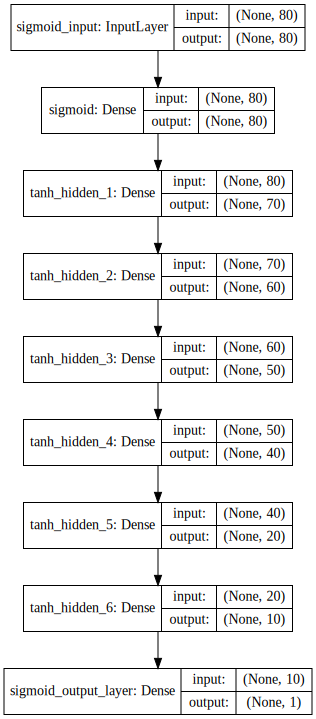

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

# Just drawing the final model
model = Sequential()
model.add(Dense(80, activation='sigmoid', input_shape=(80,), name='sigmoid'))
model.add(Dense(70, activation='tanh', name='tanh_hidden_1'))
model.add(Dense(60, activation='tanh', name='tanh_hidden_2'))
model.add(Dense(50, activation='tanh', name='tanh_hidden_3'))
model.add(Dense(40, activation='tanh', name='tanh_hidden_4'))
model.add(Dense(20, activation='tanh', name='tanh_hidden_5'))
model.add(Dense(10, activation='tanh', name='tanh_hidden_6'))
model.add(Dense(1, activation='sigmoid', name='sigmoid_output_layer'))

plot_model(model, show_shapes=True, to_file='model.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
# We have both models saved, so we'll load and submit both.
from keras.models import load_model
import pandas as pd

fully_trained = load_model('credit_scoring_3.h5')

submission_set = build_submission_keras(fully_trained)
submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'submission_last.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

special_model = load_model('credit_scoring_3_spc.h5')

submission_set = build_submission_keras(special_model)
submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'submission_last_spc.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

Both results:

** The fully trained model submission result **:

![](images/best_score_ann.png)

** The trained model with roc_auc > 0.80 in the test set submission result **:

![](images/special_submission.png)

It's hard to evaluate the network perfomance since the loss functions are calculated in a way that it's not optimized for this kind of problem.

And it's also hard to evaluate the accuracy without the roc_auc, and without a proper validation and test set.

The BOOSTING models were a lot better.

But I've decided to check a NN based approach, since deep neural networks are now a trend.

## Checkpoint

Let's try the boosting classifier

In [8]:
import utils
features_set = utils.load_features_set()
y = features_set['SeriousDlqin2yrs'].as_matrix()
x = features_set.drop(['SeriousDlqin2yrs'], axis=1).as_matrix()
x_train_f, x_test_f, y_train_f, y_test_f = utils.split_dataset(x, y, portion=0.20)

Dataset splitted from: 
	x=(150000, 80), y=(150000,)
To: 
Train Set
	x=(120000, 80), y=(120000,)
Test Set
	x=(30000, 80), y=(30000,)


In [9]:
def build_submission_skl(classifier):
    submission_feature_set = utils.load_test_feature_set()
    submission_feature_set = submission_feature_set.drop(['SeriousDlqin2yrs'], axis=1)
    x = submission_feature_set.as_matrix()

    y_predicts = classifier.predict(x)
    y_probs = classifier.predict_proba(x)
    
    submission_set = utils.load_test_set()
    submission_set .SeriousDlqin2yrs = y_predicts
    submission_set ['Probability'] = y_probs[:,:1]
    
    return submission_set

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

gb_clf = GradientBoostingClassifier()

gb_clf.fit(x_train_f, y_train_f)

#y_predicts = gb_clf.predict(x[:10])
#y_probs = gb_clf.predict_proba(x[:10])

submission_set = build_submission_skl(gb_clf)
submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'submission_gb.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

** The simple GradientBoostingClassifier without optimization got .86 **:

![](images/gb_submission.png)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer, roc_auc_score

clf = GradientBoostingClassifier()

cv_sets = ShuffleSplit(x_train_f.shape[0], n_iter = 10, 
                       test_size = 0.1, train_size=None, 
                       random_state = 0)

parameters = {
    'min_samples_split': [2, 3 ],
    'n_estimators' : [200, 300, 400],
    'max_features': ['log2', 'sqrt']
}

scorer = make_scorer(roc_auc_score)
             
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=cv_sets, n_jobs=2, verbose=6)

grid_obj = grid_obj.fit(x_train_f, y_train_f)

clf = grid_obj.best_estimator_

y_targets = clf.predict(x_test_f)

score = roc_auc_score(y_targets, y_test_f)

print("%s: %0.8f - [%s]" % ('ROC_AUC_SCORE', score, gb_clf.__class__.__name__))

submission_set = build_submission_skl(clf)
submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'optimized_gb_pc.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] max_features=log2, min_samples_split=2, n_estimators=200 ........
[CV] max_features=log2, min_samples_split=2, n_estimators=200 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=200, score=0.599307 -  14.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=200 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=200, score=0.593204 -  15.0s
[CV] max_features=log2, min_samples_split=2, n_estimators=200 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=200, score=0.583706 -  15.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=200 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=200, score=0.601291 -  15.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=200 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=200, score=0.593238 -  14.6s
[CV] max_features=log2, min_samples_split=2, n_estimators=200 ........


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.2min


[CV]  max_features=log2, min_samples_split=2, n_estimators=200, score=0.588104 -  15.0s
[CV] max_features=log2, min_samples_split=2, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=300, score=0.592137 -  20.9s
[CV] max_features=log2, min_samples_split=2, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=300, score=0.596203 -  21.1s
[CV] max_features=log2, min_samples_split=2, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=300, score=0.588605 -  21.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=300, score=0.591959 -  21.4s
[CV] max_features=log2, min_samples_split=2, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=300, score=0.594312 -  21.2s
[CV] max_features=log2, min_samples_split=2, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=2, 

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.6min


[CV]  max_features=log2, min_samples_split=3, n_estimators=300, score=0.595231 -  21.0s
[CV] max_features=log2, min_samples_split=3, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=3, n_estimators=300, score=0.595542 -  21.7s
[CV] max_features=log2, min_samples_split=3, n_estimators=300 ........
[CV]  max_features=log2, min_samples_split=3, n_estimators=300, score=0.595926 -  21.3s
[CV] max_features=log2, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=log2, min_samples_split=3, n_estimators=300, score=0.590119 -  21.7s
[CV] max_features=log2, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=log2, min_samples_split=3, n_estimators=400, score=0.598542 -  28.2s
[CV] max_features=log2, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=log2, min_samples_split=3, n_estimators=400, score=0.596850 -  28.1s
[CV] max_features=log2, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=log2, min_samples_split=3, 

[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 20.8min


[CV]  max_features=sqrt, min_samples_split=3, n_estimators=300, score=0.599943 -  25.8s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=400, score=0.595130 -  34.0s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=400, score=0.594360 -  34.3s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=400, score=0.584196 -  34.2s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=400, score=0.601652 -  34.2s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=400, score=0.596396 -  33.3s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=400 ........
[CV]  max_features=sqrt, min_samples_split=3, 

[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 23.7min finished


ROC_AUC_SCORE: 0.76844380 - [GradientBoostingClassifier]


> The tryin to tune the model gave:

![](images/bad_optimized_gb.png)

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score

import utils

def test_clf(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("%s: %0.8f - [%s]" % (roc_auc_score.__name__.upper(), roc_auc_score(y_pred, y_test), clf.__class__.__name__))
    
    return clf

def build_submission_skl(classifier):
    submission_feature_set = utils.load_test_feature_set()
    submission_feature_set = submission_feature_set.drop(['SeriousDlqin2yrs'], axis=1)
    x = submission_feature_set.as_matrix()

    y_predicts = classifier.predict(x)
    y_probs = classifier.predict_proba(x)
    
    submission_set = utils.load_test_set()
    submission_set .SeriousDlqin2yrs = y_predicts
    submission_set ['Probability'] = y_probs[:,:1]
    
    return submission_set

features_set = utils.load_features_set()
y = features_set['SeriousDlqin2yrs'].as_matrix()
x = features_set.drop(['SeriousDlqin2yrs'], axis=1).as_matrix()

x_train_f, x_test_f, y_train_f, y_test_f = utils.split_dataset(x, y, portion=0.20)

/media/rodsnjr/Files/miniconda3/envs/udacity-ml/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Dataset splitted from: 
	x=(150000, 80), y=(150000,)
To: 
Train Set
	x=(120000, 80), y=(120000,)
Test Set
	x=(30000, 80), y=(30000,)


In [3]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=391, 
                                 max_depth=4, 
                                 subsample=0.8,
                                 min_samples_split=3,
                                 min_weight_fraction_leaf=0.2,
                                 min_samples_leaf=2, verbose=1)

gb_clf = test_clf(clf, x_train_f, y_train_f, x_test_f, y_test_f)

submission_set = build_submission_skl(gb_clf)
submission_set.to_csv(utils.os.path.join(utils.DIR, 'dataset', 'fs_submission_gb.csv'),
                      index=False, 
                      columns=['Id', 'Probability'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4715           0.0198            2.45m
         2           0.4586           0.0143            2.46m
         3           0.4473           0.0105            2.44m
         4           0.4383           0.0082            2.42m
         5           0.4351           0.0062            2.41m
         6           0.4285           0.0052            2.41m
         7           0.4227           0.0050            2.40m
         8           0.4226           0.0038            2.39m
         9           0.4155           0.0032            2.38m
        10           0.4132           0.0036            2.37m
        20           0.3949           0.0010            2.24m
        30           0.3874           0.0006            2.19m
        40           0.3830           0.0003            2.17m
        50           0.3798           0.0002            2.17m
        60           0.3766           0.0001            2.11m
       

By changing a few parameters manually and submitting I've managed this

![](images/better_n_estimators.png)